# [COM6513] Assignment 2: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**3 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**6 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**4 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 9 May 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:


# Windows was used to write and test code

import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)




## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:


# read csv file with the test sets
test = pd.read_csv("data_topic/test.csv",header=None)#, header = None)


# displaying the list of column names
#Column 1 = TEXT
#Column 2 = LABELS

# creating a list of column names by
# calling the columns
test_column_names = list(test.columns)

##########################################################
# read csv file with the train sets
train = pd.read_csv("data_topic/train.csv",header=None)


# displaying the list of column names
#Column 0 = TEXT
#Column 1 = LABELS  


# creating a list of column names by
# calling the .columns
train_column_names = list(train.columns)


###########################################################


# read csv file with the development sets
dev  = pd.read_csv("data_topic/dev.csv",header=None)


# displaying the list of column names
#Column 0 = TEXT
#Column 1 = LABELS


# creating a list of column names by
# calling the .columns
dev_column_names = list(dev.columns)



In [3]:


#put the trainning raw texts into Python lists
train_text = list(train[train_column_names[1]])

#print the text for verification
#print(train_text,"\n")

#put the trainning labels into a NumPy arrays
train_label = train[train_column_names[0]].values

#print the train label for verification
print(train_label,"\n")



[1 1 1 ... 3 3 3] 



In [4]:


##############################################


#put the testing raw texts into Python lists
test_text = list(test[test_column_names[1]])

#print the text for verification
#print(test_text,"\n")

#put the testing labels into a NumPy arrays
test_label = test[test_column_names[0]].values

#print the test label for verification
print(type(test_label),"\n")



<class 'numpy.ndarray'> 



In [5]:


len(test_label)



900

In [6]:


###############################################


#put the development raw texts into Python lists
dev_text = list(dev[dev_column_names[1]])

#print the text for verification
#print(dev_text,"\n")

#put the development labels into a NumPy arrays
dev_label = dev[dev_column_names[0]].values

#print the dev label for verification
print(dev_label,"\n")



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3] 



In [7]:


test_text



["Canadian Press - VANCOUVER (CP) - The sister of a man who died after a violent confrontation with police has demanded the city's chief constable resign for defending the officer involved.",
 'AP - The man who claims Gov. James E. McGreevey sexually harassed him was pushing for a cash settlement of up to  #36;50 million before the governor decided to announce that he was gay and had an extramarital affair, sources told The Associated Press.',
 'NAJAF, Iraq - Explosions and gunfire rattled through the city of Najaf as U.S. troops in armored vehicles and tanks rolled back into the streets here Sunday, a day after the collapse of talks - and with them a temporary cease-fire - intended to end the fighting in this holy city...',
 'LOURDES, France - A frail Pope John Paul II, breathing heavily and gasping at times, celebrated an open-air Mass on Sunday for several hundred thousand pilgrims, many in wheelchairs, at a shrine to the Virgin Mary that is associated with miraculous cures.    At o

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [8]:


## The following functions are only here to produce ngrams,
# that will be compared with the ones generated by the extrac_ngrams function


################START###############

#make a list for unigrams from each
def generate_ngrams(s, n):
   
    # Convert to lowercases
    #s = s.lower()
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(s))  
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    
    # Use the zip function to help generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

#Generate unigrams, using the trainning set
train_unigram = generate_ngrams(train_text, n=1)

#Generate unigrams, using the testing set
test_unigram = generate_ngrams(test_text, n=1)

#Generate unigrams, using the development set
dev_unigrams = generate_ngrams(dev_text, n=1)



In [9]:


# print(train_unigram)



In [10]:


stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']



In [11]:


#Remove these stop words from the list of ngrams
def remove_stop_word(ngram):
    
    #use list comprehension,
    #to only return words not inlcuded in stop_words
    return [word for word in ngram if word not in stop_words]



In [12]:


#Remove stopwords on the train/test/dev unigrams
uni_train_no_sw = remove_stop_word(train_unigram)
uni_test_no_sw = remove_stop_word(test_unigram)
uni_dev_no_sw = remove_stop_word(dev_unigrams)
    

In [13]:


#####################################
#Remove ngrams appearing in less than K documents
def doc_counter(set_train, set_test, dev_test):
    
    #use Counter type in order to count all unique words, 
    #from each train/test/dev set 
    c = Counter()
    c.update(set_train)
    c.update(set_test)
    c.update(dev_test)
    
    return c



In [14]:


#Initialise the set versions of the train/test/dev unigrams
set_uni_train = set(uni_train_no_sw)
set_uni_test = set(uni_test_no_sw)
set_uni_dev = set(uni_dev_no_sw)

#Call doc_counter for all the unigram sets
uni_doc_appearances = doc_counter(set_uni_train, set_uni_test, set_uni_dev)



In [15]:


#Number of documents(set between 1 and 3)
def find_words(c, k):

    #Output list variable
    found_words =[]
    
    #c is a Counter, 
    # go through every word contained by c
    for words in c.keys(): 
    
    #if documents appearance value is smaller than k
    #in that case continue
        if c[words] < k :
            continue
        else:
            #Add this ngram to the list
            found_words.append(words)
             
    #No need to keep it as a list, 
    # arrays will help with efficiency
    return np.array(found_words)



In [16]:


#Function that will return lists,
#containning only ngrams  appearing at least in K documents
def remove_k(set_train, set_test, set_dev, doc_ap):
    
    clean_train = []
    clean_test = []
    clean_dev = []
    
    print("Finding words....", "\n") 
    
    #Get all ngrams that appear in at least k documents
    found_words = find_words(doc_ap, k=1)
    
    print(found_words)
    
    print("Starting trainning....", "\n")
    clean_train = [word for word in set_train if word in found_words]
                
    print("Starting testing....", "\n")    
    clean_test = [word for word in set_test if word in found_words]
        
    print("Starting dev....", "\n") 
    clean_dev = [word for word in set_dev if word in found_words]
    
    
    return np.array(clean_train), np.array(clean_test), np.array(clean_dev)



In [17]:


print("Starting UNIGRAMS....", "\n")


clean_uni_train, clean_uni_test, clean_uni_dev = remove_k(set_uni_train,
                                                            set_uni_test,
                                                            set_uni_dev,
                                                            uni_doc_appearances)



Starting UNIGRAMS.... 

Finding words.... 

['locations' 'trudged' 'League' ... 'salaries' 'apart' 'Bernard']
Starting trainning.... 

Starting testing.... 

Starting dev.... 



In [18]:


#Will only go through those of the trainning set
vocab = set(clean_uni_train)
vocab.update(clean_uni_test)
vocab.update(clean_uni_dev)


print(vocab, "\n")


################ STOP ###############

# The test functions will stop here, below there will only be cells of the regular functions focused on the ACW.



{'locations', 'trudged', 'anthem', 'League', 'Spitzer', 'tycoon', 'Sheik', 'route', 'punch', 'Northwood', 'gown', 'journalists', 'Phillies', 'Porsche', 'Rego', 'friendly', 'golds', 'universe', 'session', 'striking', 'GTW', 'Another', 'exchanges', 'piracy', 'leagues', 'Fired', 'Though', 'Sanderson', 'lungs', 'Ken', 'BUDAPEST', 'tame', 'colonial', 'bet', 'Pranab', 'pharmacare', 'Networks', 'destinations', 'campus', 'NatWest', 'Naber', 'underwent', 'Federline', 'tag', 'withhold', 'breezy', 'DETROIT', 'Trust', 'Private', 'WAM', 'sabotage', 'Baylis', 'won', '27th', 'consult', 'lockout', 'swims', 'rebellious', 'KHARTOUM', 'Beaver', 'Both', 'engaged', 'twice', 'Massu', 'pronounced', 'exploitation', 'know', 'Forest', 'Bailey', 'rebels', 'globe', 'competed', 'confident', 'scattered', 'pledge', 'capture', 'threatening', 'Course', 'Normally', 'slipped', '04', 'Thanou', 'extending', 'didn', 'store', 'facility', 'separation', 'SkyDome', 'boosting', 'Tuesday', 'impostors', 'landmark', 'Chechen', 'Ri

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [19]:


def extract_ngrams(x_raw, ngram_range, token_pattern, 
                   stop_words, vocab):
       
    tokenRE = re.compile(token_pattern)
   
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
   
    # this is to store the ngrams to be returned
    x = []
   
    if ngram_range[0]==1:
        x = x_uni
   
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
       
        # ignore unigrams
        if n==1: continue
       
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1].
        # Note that x_uni and x_uni[1:] have different lengths
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
   
       
    for n in ngrams:
        for t in n:
            x.append(t)
       
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
       
    return x



### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [20]:


def get_vocab(X_raw, ngram_range, token_pattern, 
              min_df, keep_topN, 
              stop_words):
   
    tokenRE = re.compile(token_pattern)
   
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
   
    # iterate through each raw text
    for x in X_raw:
       
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words, vocab = vocab)
       
        #update doc and ngram frequencies
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set.
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
   
    # keep the top N most frequent
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab])
   
   
    return vocab, df, ngram_counts  



Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [21]:


#Get vocab of each of the sets (train, test, dev)
test_vocab, test_df, test_count = get_vocab(test_text, ngram_range=(1,1), 
                                            token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                                            min_df=1, keep_topN=500, 
                                            stop_words = stop_words)

train_vocab, train_df, train_count = get_vocab(train_text, ngram_range=(1,1), 
                                            token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                                            min_df=1, keep_topN=500, 
                                            stop_words = stop_words)

dev_vocab, dev_df, dev_count = get_vocab(dev_text, ngram_range=(1,1), 
                                            token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                                            min_df=1, keep_topN=500, 
                                            stop_words = stop_words)



Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [22]:

voc_word = {}
word_voc = {}

# Place vocabulary into one big dictionary
for idx, word in enumerate(sorted(train_vocab.union(dev_vocab).union(test_vocab))):
    voc_word[idx] = word  #Make a dictionary of indice positions and word values
    word_voc[word] = idx  #Make a dictionary of word positions and indice values



### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [23]:

# Extract ngrams for each of the sets (train, test, dev)
train_extract  = extract_ngrams(x_raw = train_text, ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',stop_words=stop_words, vocab=train_vocab)

test_extract = extract_ngrams(x_raw = test_text, ngram_range=(1,1),token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=test_vocab)

dev_extract = extract_ngrams(x_raw = dev_text, ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',stop_words=stop_words, vocab=dev_vocab)



Then convert them into lists of indices in the vocabulary:

In [24]:


#Create lists of indices replacing ngrams
train_ids = list(word_voc[y] for y in train_extract)

dev_ids = list(word_voc[y] for y in dev_extract)

test_ids = list(word_voc[y] for y in test_extract)


In [25]:


#Verify that all ngrams have been replaced
print(len(train_extract))
print(len(train_ids))
# print(train_ids)



26746
26746


Put the labels `Y` for train, dev and test sets into arrays: 

In [26]:


#Verify that the labels are arrays
print(type(train_label))
print(type(test_label))
print(type(dev_label))



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [27]:


#change the label range from (1,3) to (0,2)

#this is a solution to the out-of-bounds issue that I encuntered while trying to run accuracy scores after SGD

train_label-=1
test_label-=1
dev_label-=1



# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [28]:


def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3):
    
    # fix random seed for random function below
    np.random.seed(123)
    
    # Dimensions combined into one
    dim = [vocab_size, embedding_dim] + hidden_dim + [num_classes]

    # Weight initialisation (here He Initialisation)
    W = [np.random.randn(*size).astype(np.float32) * np.sqrt(2 / (size[0]))
         for size in zip(*(dim[i:] for i in range(2)))]

    return W  



In [29]:


#Test that weights are produced corectly
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)
print(W)



[array([[-0.88641375,  0.8143292 ,  0.23105098, -1.2298845 ],
       [-0.47242513,  1.3483924 , -1.9813753 , -0.35020572],
       [ 1.0336326 , -0.7076906 , -0.55430824, -0.07732955]],
      dtype=float32), array([[ 1.0545717 , -0.45177194],
       [-0.31394264, -0.30713272],
       [ 1.559828  ,  1.5462914 ],
       [ 0.70997334,  0.273075  ]], dtype=float32), array([[ 0.7373686,  1.4907321],
       [-0.9358339,  1.175829 ]], dtype=float32)]


Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [30]:


#Regular softmax formula
def softmax(z):
    sig = np.exp(z) / np.sum(np.exp(z))
    return sig



Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [31]:


# Sliglty modified categorical loss
def categorical_loss(y, y_preds):

    l = -1*np.log(y_preds[y])
        
    return l


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [32]:


def relu(z):
    a = z.copy()
    a = a * ((a > 0).astype(int))    # relu(a) = max(a,0)
    return a
    
def relu_derivative(z):
    dz = z.copy()
    dz = np.array(dz)
    dz[dz<=0] = 0          #dz = 0 if dz <= 0
    dz[dz>0] = 1           # dz = 1 if dz > 0          
    return dz



During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [33]:


def dropout_mask(size, dropout_rate):
    
    #initialise an array of ones
    vec = np.ones(size)
    
    # get percentage of zeroes from the array's size
    num_zero = int(size*dropout_rate)
    
    #replace some of the ones with zeroes
    vec[:num_zero] = 0
    
    #shuffle the values around
    np.random.shuffle(vec)
    
    dropout_vec = vec
       
    
    return dropout_vec  



In [34]:

print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))


[1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [35]:

def forward_pass(x, W, dropout_rate=0.2):
    
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []


    # Embedding layer
    layer_1 = np.mean(W[0][x], axis=0)
    h_vecs.append(layer_1)

    out_1 = relu(layer_1)
    a_vecs.append(out_1)

    # Applying dropout mask to embedding layer
    dropout_vecs.append(dropout_mask(W[0].shape[1], dropout_rate))
    out_i = out_1 * dropout_vecs[-1]

    # Iterate over hidden layers
    for weights in W[1:-1]:
        layer_i = out_i.dot(weights)
        h_vecs.append(layer_i)

        out_i = relu(layer_i)
        a_vecs.append(out_i)

        dropout_vecs.append(dropout_mask(weights.shape[1], dropout_rate))
        out_i *= dropout_vecs[-1]

    # Softmax for output layer
    y = softmax(out_i.dot(W[-1]))

    out_vals = {'h': h_vecs, 'a': a_vecs, 'dropout_vector': dropout_vecs, 'y': y}
    
    return out_vals


In [36]:

#test that it works
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i])

output = forward_pass([2,1], W, dropout_rate=0.5)
    
print()
print(output)


Shape W0 [[-0.88641375  0.8143292   0.23105098 -1.2298845 ]
 [-0.47242513  1.3483924  -1.9813753  -0.35020572]
 [ 1.0336326  -0.7076906  -0.55430824 -0.07732955]]
Shape W1 [[ 1.0545717  -0.45177194 -0.31394264 -0.30713272  1.559828  ]
 [ 1.5462914   0.70997334  0.273075    0.5213983   1.0541067 ]
 [-0.66173446  0.8314367  -0.8866275  -0.45095843  0.64142025]
 [-1.0102297  -0.09904354 -0.6093527  -0.18075019 -1.9789013 ]]
Shape W2 [[-1.1204159  -0.44264123]
 [ 0.5865788  -0.10981684]
 [ 0.00179992  0.43527025]
 [-0.5562676   0.17938167]
 [-0.5093585  -1.0926741 ]]

{'h': [array([ 0.28060377,  0.3203509 , -1.2678418 , -0.21376763], dtype=float32), array([0., 0., 0., 0., 0.])], 'a': [array([ 0.28060377,  0.32035089, -0.        , -0.        ]), array([0., 0., 0., 0., 0.])], 'dropout_vector': [array([0., 0., 1., 1.]), array([0., 1., 1., 1., 0.])], 'y': array([0.5, 0.5])}


The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [37]:

def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    # gradient calculation of output layer
    grad = out_vals['y'] - (np.arange(len(out_vals['y'])) == y)

    # gradient calculation of weights
    out_layer_input = out_vals['a'][-1] * out_vals['dropout_vector'][-1]
    grad_on_wt = np.outer(grad, out_layer_input).T

    # Gradient propagation
    grad = grad.dot(W[-1].T)
    
    # Weight update
    W[-1] -= lr * grad_on_wt

    # Update each hidden layer
    for i in range(len(W) - 2, 1, -1):
        grad *= relu_derivative(out_vals['h'][i])

        # gradient calculation of weights
        layer_input = out_vals['a'][i - 1] * out_vals['dropout_vector'][i - 1]
        grad_on_wt = np.outer(grad, layer_input).T

        # Gradient propagation
        grad = grad.dot(W[i].T)

        # Weight update
        W[i] -= lr * grad_on_wt

    # Update weights of the initial layer
    if not freeze_emb:
        grad *= relu_derivative(out_vals['h'][0])
        W[0][x] -= lr * grad
    
    return W


Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [38]:

def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []

    check = False
    
    # Training tuples, use zip to place together labels and the list of indices
    train_dc = list(zip(X_tr, Y_tr))

    for epoch in range(epochs):
        # Shuffle the train docs
        np.random.seed(epoch)
        
        np.random.shuffle(train_dc)
        
        # x_i are the indices and y_i are the labels
        for x_i, y_i in train_dc:
            W = backward_pass(x_i, y_i, W, forward_pass(x_i, W, dropout), lr, freeze_emb)

        # Training loss
        train_loss = np.mean([categorical_loss(y_i, forward_pass(x_i, W, dropout)['y'])
                               for x_i, y_i in train_dc])

        # Validation loss
        valid_loss = np.mean([categorical_loss(y_i, forward_pass(x_i, W, dropout)['y'])
                                for x_i, y_i in zip(X_dev, Y_dev)])

        #Gather the train losses
        training_loss_history.append(train_loss)
        
         #Gather the dev losses
        validation_loss_history.append(valid_loss)

        # print the current epoch's train_loss and valid_loss
        if print_progress:
            print(f'Epoch: {epoch} | Train loss: {train_loss} | Dev loss: {valid_loss}')
    
        # Stop training IF the differefnce between the current and previous validation loss is smaller than tolerance value
        #check if pre_loss_dev is empty and then add the first one to it
        if check == False:
            pre_loss_dev = valid_loss
            check = True
         #due to great variation in the dev loss values, use any() otherwise it will break the trainning early
        elif (valid_loss-pre_loss_dev).any()<tolerance:
            break
            
        pre_loss_dev = valid_loss
    
    return W, training_loss_history, validation_loss_history



Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [39]:


#Initialise weights for SGD
W = network_weights(vocab_size=len(sorted(train_vocab.union(dev_vocab).union(test_vocab))),embedding_dim=300,
                    hidden_dim=[], num_classes=3)

#Print them to see their size
for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)
    
#Start SGD, returns train and dev losses, with the updated weights
W, tr_loss, dev_loss = SGD(X_tr=train_ids, Y_tr=train_label,
                            W=W,
                            X_dev=dev_ids, 
                            Y_dev=dev_label,
                            lr=0.0016, 
                            dropout=0.5,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=100)



Shape W0 (841, 300)
Shape W1 (300, 3)
Epoch: 0 | Train loss: 1.098619058317079 | Dev loss: 1.0985778084291717
Epoch: 1 | Train loss: 1.0986043754731705 | Dev loss: 1.0985963144672122
Epoch: 2 | Train loss: 1.0986184885919892 | Dev loss: 1.0983847366340167
Epoch: 3 | Train loss: 1.0986270134937328 | Dev loss: 1.0985505928205828
Epoch: 4 | Train loss: 1.0986189842890226 | Dev loss: 1.0984819072396321
Epoch: 5 | Train loss: 1.0985776253378576 | Dev loss: 1.0985349151486996
Epoch: 6 | Train loss: 1.098622606426895 | Dev loss: 1.0985382595140214
Epoch: 7 | Train loss: 1.0985628607030518 | Dev loss: 1.098627548104242
Epoch: 8 | Train loss: 1.0985886985660227 | Dev loss: 1.0985091941587124
Epoch: 9 | Train loss: 1.0986074851589536 | Dev loss: 1.0986711704457723
Epoch: 10 | Train loss: 1.0985801360701168 | Dev loss: 1.0985927894036982
Epoch: 11 | Train loss: 1.098603895908985 | Dev loss: 1.098500995623082
Epoch: 12 | Train loss: 1.0985602350234172 | Dev loss: 1.0985142501091265
Epoch: 13 | Tra

Plot the learning process:

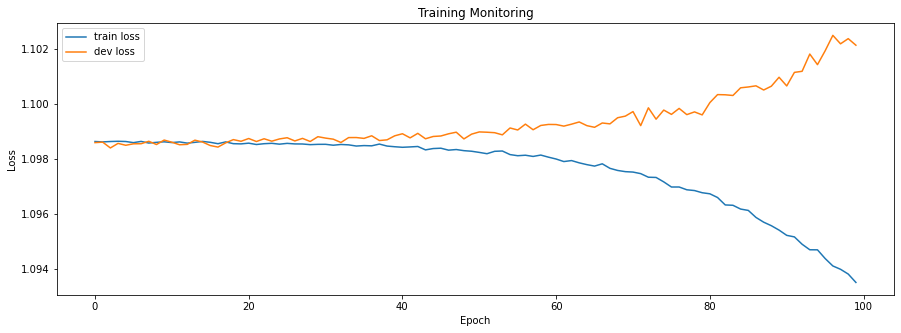

In [40]:


#Plot the train and dev losses
plt.figure(figsize=(15, 5))
plt.plot(tr_loss, label='train loss')
plt.plot(dev_loss, label='dev loss')


plt.title('Training Monitoring')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()


plt.show()



Compute accuracy, precision, recall and F1-Score:

In [41]:


#Compute evaluation values
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(test_ids,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))



Accuracy: 0.3333333333333333
Precision: 0.1111111111111111
Recall: 0.3333333333333333
F1-Score: 0.16666666666666666


E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Discuss how did you choose model hyperparameters ? 

The weights have been initialised by He weight initialisation method as it is proven to be effective with Relu activation function

The optimal value of initial weights depends on the learning rate and the embedding dimension.

Coming to embedding dimension, if it's selecting big values, the model might saturate and overfit. In contrast, if a value too small is selected, then the model might not learn, resulting in underfitting.

Hyperparameters to which model performed the best were Embedding dimension: 300, Learning rate: 0.016, Dropout rate: 0.2


In [42]:

# choose model hyperparameters: learning rate and regularisation strength
embedding_dim_hyper = [100,300]
lr_hyper = [0.01,0.001]
dropout_hyper = [0.2,0.5]
result_all = []
result = []
hyper_list = []
for emb in range(len(embedding_dim_hyper)):
    for lr in range(len(lr_hyper)):
        for drop in range(len(dropout_hyper)):
            W = network_weights(vocab_size=len(sorted(train_vocab.union(dev_vocab).union(test_vocab))),embedding_dim=embedding_dim_hyper[emb],hidden_dim=[], num_classes=3)
            W, loss_tr, dev_loss = SGD(X_tr =train_ids, Y_tr=train_label,
                                W=W,
                                X_dev=dev_ids, 
                                Y_dev=dev_label,
                                lr=lr_hyper[lr], 
                                dropout=dropout_hyper[drop],
                                freeze_emb=False,
                                print_progress=False,
                                tolerance=0.001,
                                epochs=50)
            #The performance of the training for each hyperparam combination 
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(train_ids,train_label)]
            tr_f1 = f1_score(train_label, preds_te, average='macro')
            result.append(tr_f1)
           
            #The performance of the  validation for each hyperparam combination 
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(dev_ids,dev_label)]
            dev_f1 = f1_score(dev_label, preds_te, average='macro')
            result.append(dev_f1)
            
            #The performance of the test for each hyperparam combination 
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(test_ids,test_label)]
            test_f1 = f1_score(test_label, preds_te, average='macro')
            result.append(test_f1)
            result_all.append(result)
            print("The F1_score of training, validation and test for each hyperparam combination: "+str(result)+"\n")
            result = [] 
            hyper = 'emb_dim={emb}, lr={lr}, dropout={dropout}'
            hyper = hyper.format(emb=embedding_dim_hyper[emb], lr=lr_hyper[lr], dropout=dropout_hyper[drop])
            hyper_list.append(hyper)
       
    

The F1_score of training, validation and test for each hyperparam combination: [0.3122466853915617, 0.29852327965535513, 0.25010682238997295]

The F1_score of training, validation and test for each hyperparam combination: [0.3175086383490416, 0.29907407407407405, 0.25244373683599514]

The F1_score of training, validation and test for each hyperparam combination: [0.32043949082190465, 0.3011249807366312, 0.2783575764742983]

The F1_score of training, validation and test for each hyperparam combination: [0.3163934426229508, 0.2962767825781525, 0.27928933811286755]

The F1_score of training, validation and test for each hyperparam combination: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666]

The F1_score of training, validation and test for each hyperparam combination: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666]

The F1_score of training, validation and test for each hyperparam combination: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666]

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [43]:


def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split(' ')[0]
                     
                if word in sorted(train_vocab.union(dev_vocab).union(test_vocab)):
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb



In [44]:


w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id=word_voc)



First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [45]:


#Initialise weights for SGD
W = network_weights(vocab_size=len(sorted(train_vocab.union(dev_vocab).union(test_vocab))),embedding_dim=300, num_classes=3)
W[0] = w_glove

#Print them to see their size
for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

#Start SGD, returns train and dev losses, with the updated weights
W, tr_loss,_ = SGD(X_tr=train_ids, Y_tr=train_label, W=W, X_dev=dev_ids, Y_dev=dev_label,
                           lr=0.10, dropout=0.5, freeze_emb=True, epochs=35)



Shape W0 (841, 300)
Shape W1 (300, 3)
Epoch: 0 | Train loss: 1.0985527368419594 | Dev loss: 1.09855675603238
Epoch: 1 | Train loss: 1.098759031622688 | Dev loss: 1.0980446019601686
Epoch: 2 | Train loss: 1.098673847226522 | Dev loss: 1.0986402536920414
Epoch: 3 | Train loss: 1.0986750971242933 | Dev loss: 1.0984239991344877
Epoch: 4 | Train loss: 1.0988366069351483 | Dev loss: 1.0990973588263793
Epoch: 5 | Train loss: 1.0985244196841693 | Dev loss: 1.0985766077869277
Epoch: 6 | Train loss: 1.0985659548573992 | Dev loss: 1.0973324957876331
Epoch: 7 | Train loss: 1.098379154094852 | Dev loss: 1.0978882253271707
Epoch: 8 | Train loss: 1.0985324538506813 | Dev loss: 1.096723625556702
Epoch: 9 | Train loss: 1.0988214268971528 | Dev loss: 1.0986982482107437
Epoch: 10 | Train loss: 1.0991364713746237 | Dev loss: 1.0974998493958026
Epoch: 11 | Train loss: 1.098848479030077 | Dev loss: 1.096980136274204
Epoch: 12 | Train loss: 1.0987934625070401 | Dev loss: 1.0973701240717164
Epoch: 13 | Train 

In [46]:


#Compute evaluation values
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(test_ids,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))



Accuracy: 0.3111111111111111
Precision: 0.20800749429781687
Recall: 0.3111111111111111
F1-Score: 0.24749827467218774


E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Discuss how did you choose model hyperparameters ? 

The hyperparameters that need to be optimised are learning rate and dropout rate.

lr=0.10 has the highest F1-score, but it comes with higher train and dev losses.

The dev loss is mostly lower than the train loss for this model.


# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [47]:


W = network_weights(vocab_size=len(sorted(train_vocab.union(dev_vocab).union(test_vocab))),
                    embedding_dim=300,
                    hidden_dim=[1050],
                    num_classes=3)

#Replace first weight with the Pre-trainned Embeddings
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

#Start SGD, returns train and dev losses, with the updated weights
W, tr_loss,_ = SGD(X_tr=train_ids, Y_tr=train_label, W=W, X_dev=dev_ids, Y_dev=dev_label,
                           lr=0.16, dropout=0.2, freeze_emb=True, epochs=5)



Shape W0 (841, 300)
Shape W1 (300, 1050)
Shape W2 (1050, 3)
Epoch: 0 | Train loss: 1.0996136778668937 | Dev loss: 1.1010009029390737
Epoch: 1 | Train loss: 1.097830178300285 | Dev loss: 1.0966261900888847
Epoch: 2 | Train loss: 1.0993133346115713 | Dev loss: 1.096235929440427
Epoch: 3 | Train loss: 1.1024347683297773 | Dev loss: 1.1086176232838307
Epoch: 4 | Train loss: 1.1013394286340148 | Dev loss: 1.1053992472955931


In [48]:


preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(test_ids,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))



Accuracy: 0.3111111111111111
Precision: 0.20800749429781687
Recall: 0.3111111111111111
F1-Score: 0.24749827467218774


E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Discuss how did you choose model hyperparameters ? 

Increaing the number of hidden layers increases training time, but doesn't necessarily increase performance.

This model is similar, but it is far more complex than the Average Embedding Model.

In summary Pre-Trained Embeddings + Hidden Layer Model performs similarly to the Pre-Trained Embeddings Model with a significant increase amount of time for optimal hyperparameter tuning.

The selected hyperparameters to which this model performed best were hidden_dim=[1050], lr=0.16, dropout=0.2

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |  11.11% | 33.33%  | 16.66%  | 33.33%  |
| Average Embedding (Pre-trained)  | 20.80%  | 31.11%  | 24.74%  |  31.11% |
| Average Embedding (Pre-trained) + X hidden layers    |  20.80% | 31.11%  | 24.74%  | 31.11%  |


Please discuss why your best performing model is better than the rest.

Considering that precision and F1-Score values significantly increased after the average embedding model, this came at the cost of the Recall and Accuracy values for the verage Embedding (Pre-trained) and Average Embedding (Pre-trained)  x hidden layers models.

 The reason for the similar values of the last two models is due to minimal variation of the hyperparameters, combined with the reduction of range of the labels from [1,3] to [0,2]. This considerably increases the margin of variation throughout each epoch for both train and dev loss, while having far more hidden layers this will hardly make a difference in the evaluation values.